In [1]:
import sys
import os

import pandas as pd
import scanpy as sc
import numpy as np
import warnings

import torch
import torch.nn.functional as F
import torch.nn as nn
import scipy
from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, TensorDataset
from torch.nn import DataParallel
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
import anndata
import seaborn as sns
import matplotlib.font_manager
from matplotlib import rcParams
import scanpy as sc
font_list = []
fpaths = matplotlib.font_manager.findSystemFonts()
for i in fpaths:
    try:
        f = matplotlib.font_manager.get_font(i)
        font_list.append(f.family_name)
    except RuntimeError:
        pass

font_list = set(font_list)
plot_font = 'Helvetica' if 'Helvetica' in font_list else 'FreeSans'
rcParams['font.family'] = plot_font
rcParams.update({'font.size': 10})
rcParams.update({'figure.dpi': 300})
rcParams.update({'figure.figsize': (3,3)})
rcParams.update({'savefig.dpi': 500})
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

import sample_squidiff
from Squidiff.scrna_datasets import Drug_dose_encoder


In [2]:
def cal_metric(x1,x2):
    r2 = r2_score(x1, x2)
    pearsonr,_ = scipy.stats.pearsonr(x1,x2)
    print('r2=',r2)
    print('pearsonr=',pearsonr)
    return r2, pearsonr

from scipy.stats import pearsonr, spearmanr
def pearson_mean(data1, data2):
    sum_pearson_1 = 0
    sum_pearson_2 = 0
    for i in range(data1.shape[0]):
        pearsonr_ = pearsonr(data1[i], data2[i])
        sum_pearson_1 += pearsonr_[0]
        sum_pearson_2 += pearsonr_[1]
    return sum_pearson_1/data1.shape[0], sum_pearson_2/data1.shape[0]

def pearson_list(data1, data2):
    pearson_list = np.zeros(data1.shape[0])
    for i in range(data1.shape[0]):
        pearsonr_ = pearsonr(data1[i], data2[i])
        pearson_list[i] = pearsonr_[0]
    return pearson_list


def r2_mean(data1, data2):
    sum_r2_1 = 0
    for i in range(data1.shape[0]):
        r2_score_ = r2_score(data1[i], data2[i])
        sum_r2_1 += r2_score_           
    return sum_r2_1/data1.shape[0]

def mse_mean(data1, data2):
    sum_mse_1 = 0
    for i in range(data1.shape[0]):
        mse_score_ = mean_squared_error(data1[i], data2[i])
        sum_mse_1 += mse_score_           
    return sum_mse_1/data1.shape[0]


In [3]:
def run_sampler(model_path,train_adata_path,control_adata_path,test_adata_path):
    sampler = sample_squidiff.sampler(
        model_path = model_path,
        gene_size = 200,
        output_dim = 200,
        use_drug_structure = True
    )
    #train_adata = sc.read_h5ad(train_adata_path)
    test_adata = sc.read_h5ad(test_adata_path)
    control_adata = sc.read_h5ad(control_adata_path)
    drug_type_list = test_adata.obs['SMILES'].to_list()
    dose_list = test_adata.obs['dose'].to_list()
    encode_drug_doses = torch.tensor(Drug_dose_encoder(drug_type_list, dose_list, comb_num=1)).to('cuda')

    z_sem = sampler.model.encoder(x_start = torch.tensor(test_adata.X.toarray()).to('cuda'),
                                  drug_dose =  encode_drug_doses,
                                  control_feature = torch.tensor(control_adata.X.toarray()).to('cuda')
                                 )
    sample_interp = sampler.pred(
                        z_sem = z_sem,
                        gene_size =  test_adata.shape[1]
    )
    return sample_interp,test_adata

In [68]:
r2_all=[]
pearsonr_all=[]
sample_interp,test_adata=run_sampler(model_path='sciplex_results_drug_split_0/model.pt',
            train_adata_path='datasets/sci_plex_train_drug_split_0.h5ad',
            control_adata_path='datasets/sci_plex_test_drug_split_0_control.h5ad',                         
            test_adata_path='datasets/sci_plex_test_drug_split_0.h5ad',
           )
r2, pearsonr = cal_metric(sample_interp.mean(axis=0).detach().cpu().numpy().flatten(), 
           test_adata.X.toarray().mean(axis=0).flatten())

r2_all.append(['squidiff',r2])
pearsonr_all.append(['squidiff',pearsonr])

sample_interp,test_adata=run_sampler(model_path='sciplex_results_drug_split_1/model.pt',
            train_adata_path='datasets/sci_plex_train_drug_split_1.h5ad',
            control_adata_path='datasets/sci_plex_test_drug_split_1_control.h5ad',                              
            test_adata_path='datasets/sci_plex_test_drug_split_1.h5ad',
           )
r2, pearsonr = cal_metric(sample_interp.mean(axis=0).detach().cpu().numpy().flatten(), 
           test_adata.X.toarray().mean(axis=0).flatten())

r2_all.append(['squidiff',r2])
pearsonr_all.append(['squidiff',pearsonr])

sample_interp,test_adata=run_sampler(model_path='sciplex_results_drug_split_2/model.pt',
            train_adata_path='datasets/sci_plex_train_drug_split_2.h5ad',
            control_adata_path='datasets/sci_plex_test_drug_split_2_control.h5ad',                              
            test_adata_path='datasets/sci_plex_test_drug_split_2.h5ad',
           )
r2, pearsonr = cal_metric(sample_interp.mean(axis=0).detach().cpu().numpy().flatten(), 
           test_adata.X.toarray().mean(axis=0).flatten())

r2_all.append(['squidiff',r2])
pearsonr_all.append(['squidiff',pearsonr])

pd.DataFrame(r2_all).to_csv('sciplex_squidiff_r_unseen_drug.csv')
pd.DataFrame(pearsonr_all).to_csv('sciplex_squidiff_pearsonr_unseen_drug.csv')


load model and diffusion...
diffusion num of steps =  1000
r2= 0.9928635954856873
pearsonr= 0.9985364056854918
load model and diffusion...
diffusion num of steps =  1000
r2= 0.9923601746559143
pearsonr= 0.9987408752533256
load model and diffusion...
diffusion num of steps =  1000
r2= 0.9921736121177673
pearsonr= 0.9990513128793629


In [69]:
r2_all=[]
pearsonr_all=[]
sample_interp,test_adata=run_sampler(model_path='sciplex_results_random_split_0/model.pt',
            train_adata_path='datasets/sci_plex_train_random_split_0.h5ad',
            control_adata_path='datasets/sci_plex_test_random_split_0_control.h5ad',                         
            test_adata_path='datasets/sci_plex_test_random_split_0.h5ad',
           )
r2, pearsonr = cal_metric(sample_interp.mean(axis=0).detach().cpu().numpy().flatten(), 
           test_adata.X.toarray().mean(axis=0).flatten())

r2_all.append(['squidiff',r2])
pearsonr_all.append(['squidiff',pearsonr])

sample_interp,test_adata=run_sampler(model_path='sciplex_results_random_split_1/model.pt',
            train_adata_path='datasets/sci_plex_train_random_split_1.h5ad',
            control_adata_path='datasets/sci_plex_test_random_split_1_control.h5ad',                              
            test_adata_path='datasets/sci_plex_test_random_split_1.h5ad',
           )
r2, pearsonr = cal_metric(sample_interp.mean(axis=0).detach().cpu().numpy().flatten(), 
           test_adata.X.toarray().mean(axis=0).flatten())

r2_all.append(['squidiff',r2])
pearsonr_all.append(['squidiff',pearsonr])

sample_interp,test_adata=run_sampler(model_path='sciplex_results_random_split_2/model.pt',
            train_adata_path='datasets/sci_plex_train_random_split_2.h5ad',
            control_adata_path='datasets/sci_plex_test_random_split_2_control.h5ad',                              
            test_adata_path='datasets/sci_plex_test_random_split_2.h5ad',
           )
r2, pearsonr = cal_metric(sample_interp.mean(axis=0).detach().cpu().numpy().flatten(), 
           test_adata.X.toarray().mean(axis=0).flatten())

r2_all.append(['squidiff',r2])
pearsonr_all.append(['squidiff',pearsonr])

pd.DataFrame(r2_all).to_csv('sciplex_squidiff_r_random.csv')
pd.DataFrame(pearsonr_all).to_csv('sciplex_squidiff_pearsonr_random.csv')


load model and diffusion...
diffusion num of steps =  1000
r2= 0.9869873523712158
pearsonr= 0.9991739749932972
load model and diffusion...
diffusion num of steps =  1000
r2= 0.9720207452774048
pearsonr= 0.9967868975453338
load model and diffusion...
diffusion num of steps =  1000
r2= 0.9907902479171753
pearsonr= 0.9986815616814826


In [4]:
from statannotations.Annotator import Annotator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


In [16]:
def plot_comp(score1,score2,x,y,):
    # Concatenate your data
    all_ = pd.concat([pd.DataFrame(score1),
                      pd.DataFrame(score2)], axis=0)
    all_.columns = [x, y]
    custom_palette = dict(zip(['squidiff','PRnet'], 
                              ['#0c457d','#73adf5']))


    # Create the boxplot
    fig, ax = plt.subplots(1, 1, dpi=1000, figsize=(2.5, 1.5))
    g1 = sns.barplot(data=all_, x=x,
                         y=y,ax=ax,
                    palette=custom_palette, 

                    )
    plt.ylim([0.9,1])
    plt.ylabel('')
    plt.xlabel('')
    # Set up the Annotator
    annotator = Annotator(g1, 
                         data=all_, 
                         x=x,
                         y=y,
                         pairs=[('squidiff', 'PRnet')], 
                         verbose=2,
                         )

    annotator.configure(test='t-test_ind',text_format='star')
    annotator.apply_test(alternative='greater')
    annotator.annotate()
    # Show the plot
    plt.show()


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

squidiff vs. PRnet: t-test independent samples, P_val:3.584e-02 t=2.434e+00


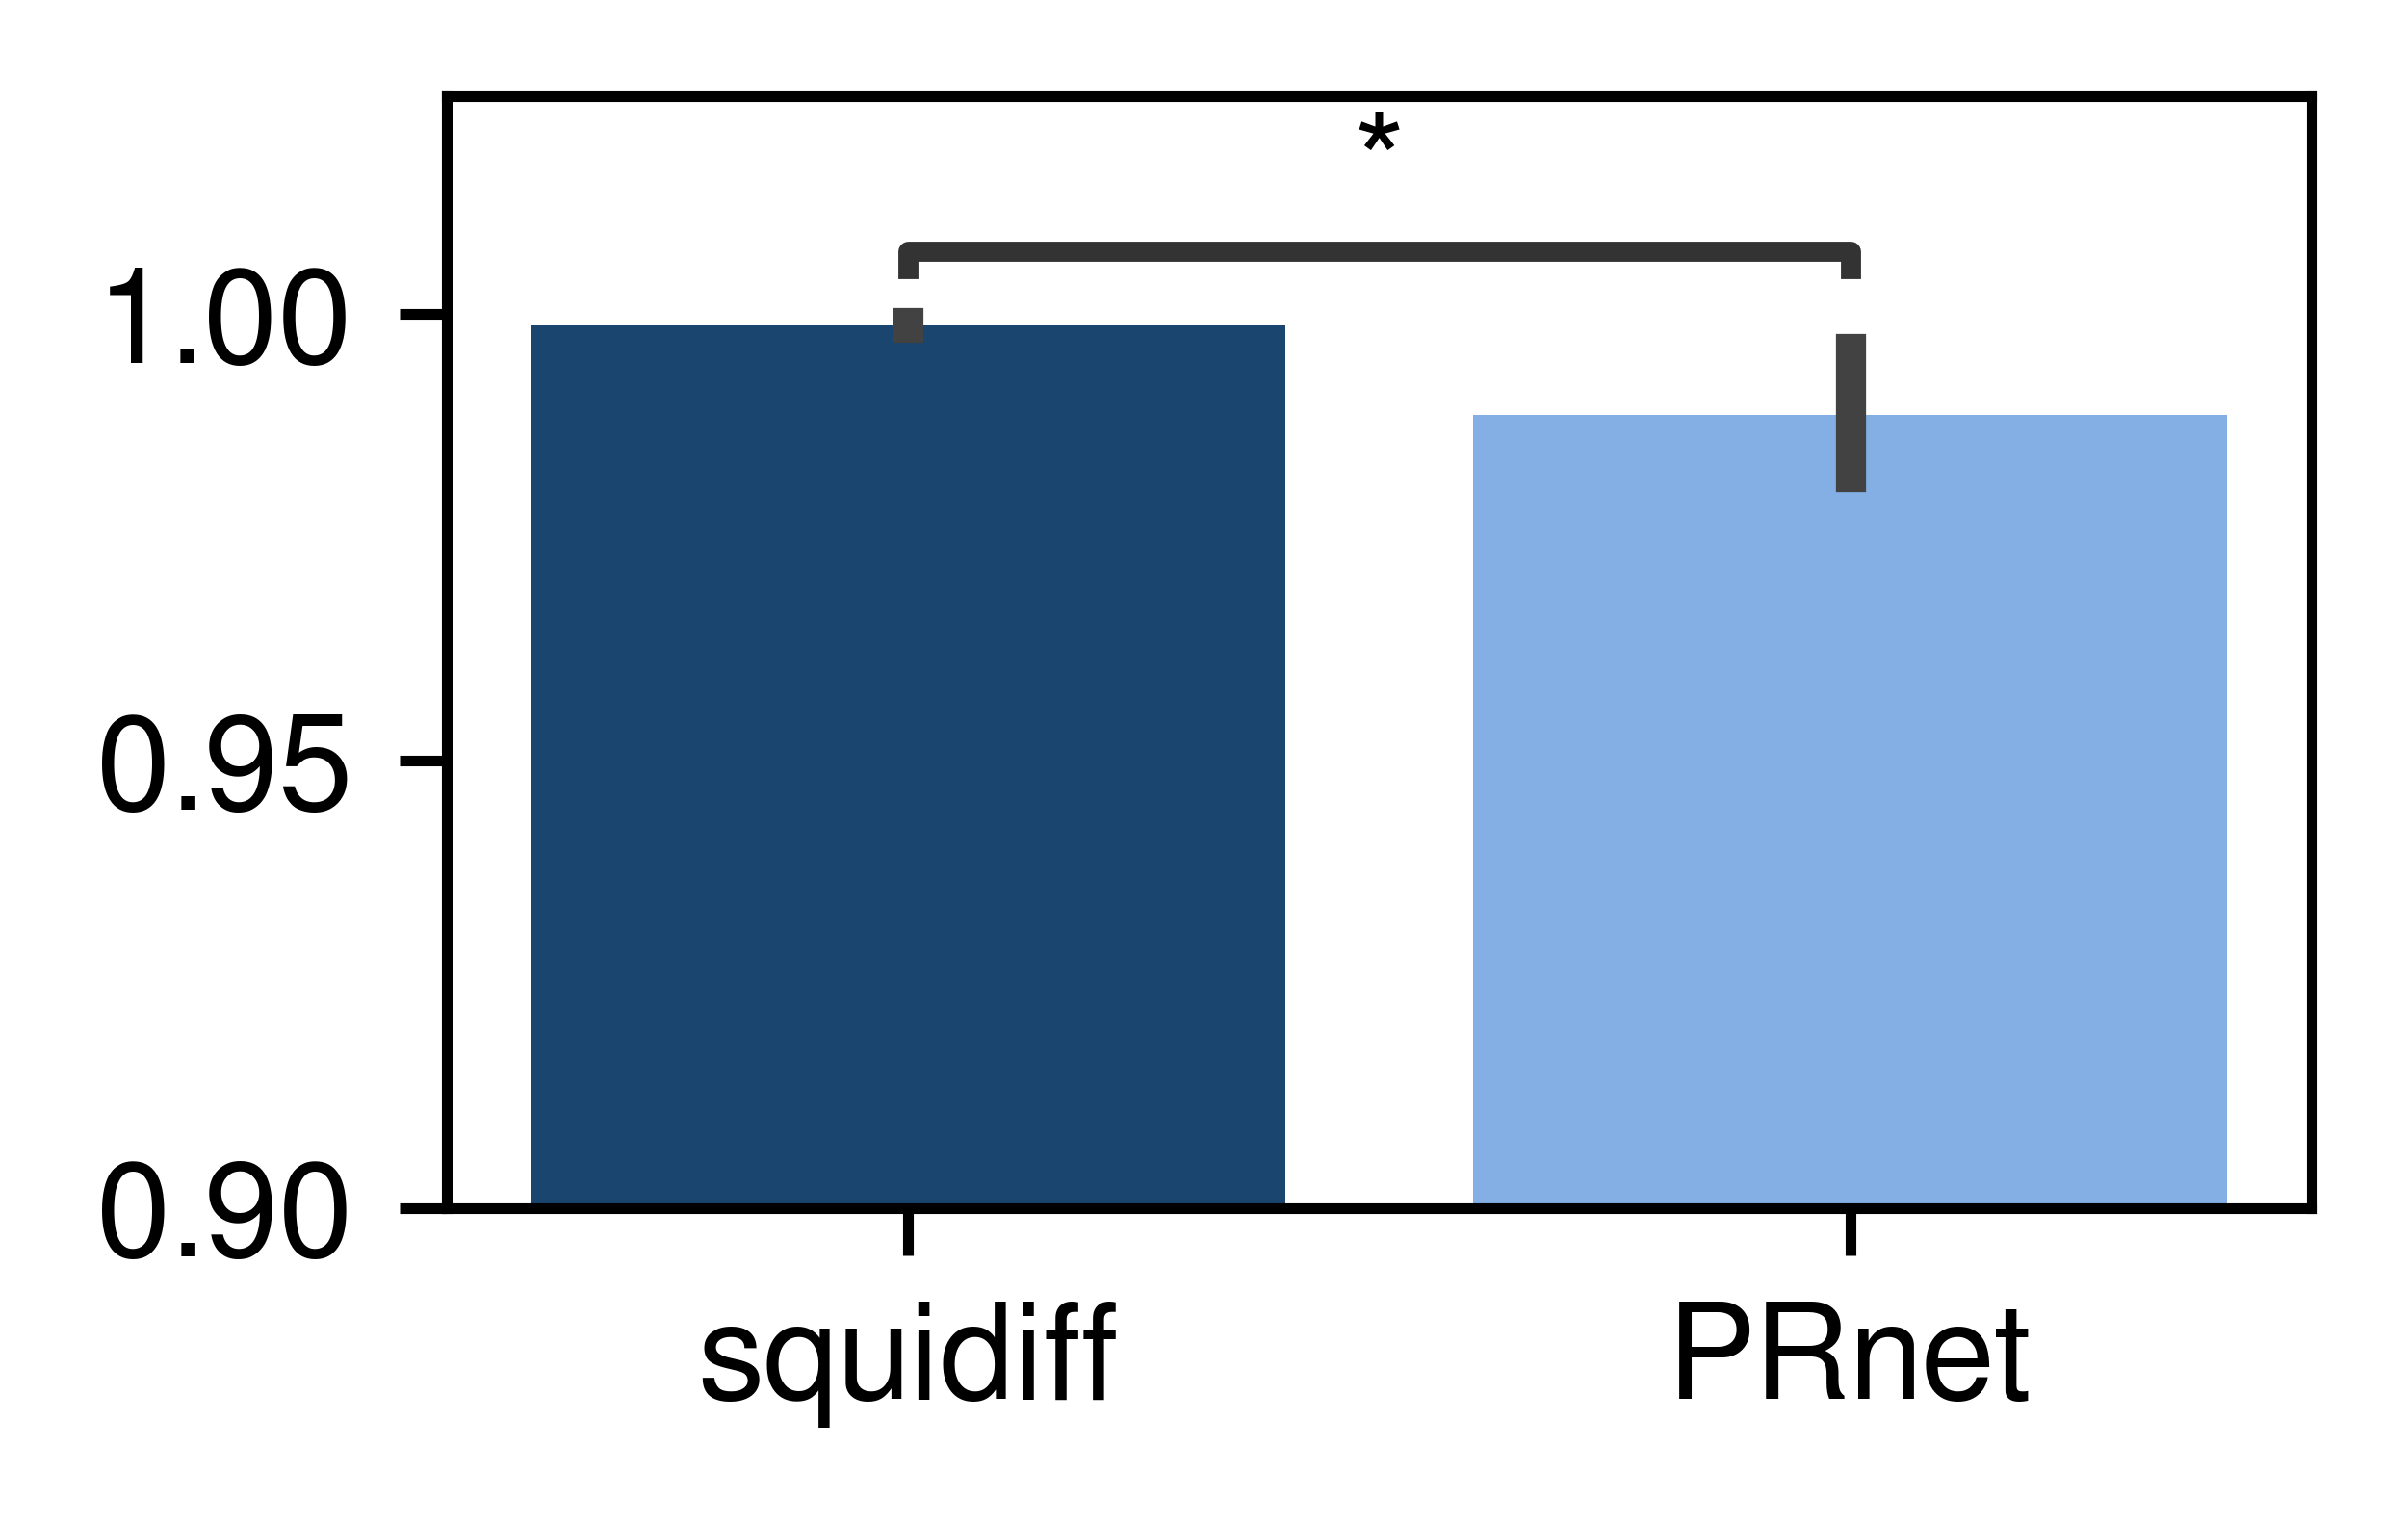

In [17]:
pearsonr_squidiff = pd.read_csv('sciplex_squidiff_pearsonr_unseen_drug.csv',index_col = 0
                               )
pearsonr_prnet = pd.read_csv('../Squidiff_project/PRnet/sciplex_PRnet_pearsonr_unseen_drug.csv',index_col = 0
                               )
plot_comp(score1 = pearsonr_squidiff,
          score2 = pearsonr_prnet,
          x='method',
          y='pearsonr'
         )

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

squidiff vs. PRnet: t-test independent samples, P_val:1.670e-02 t=3.184e+00


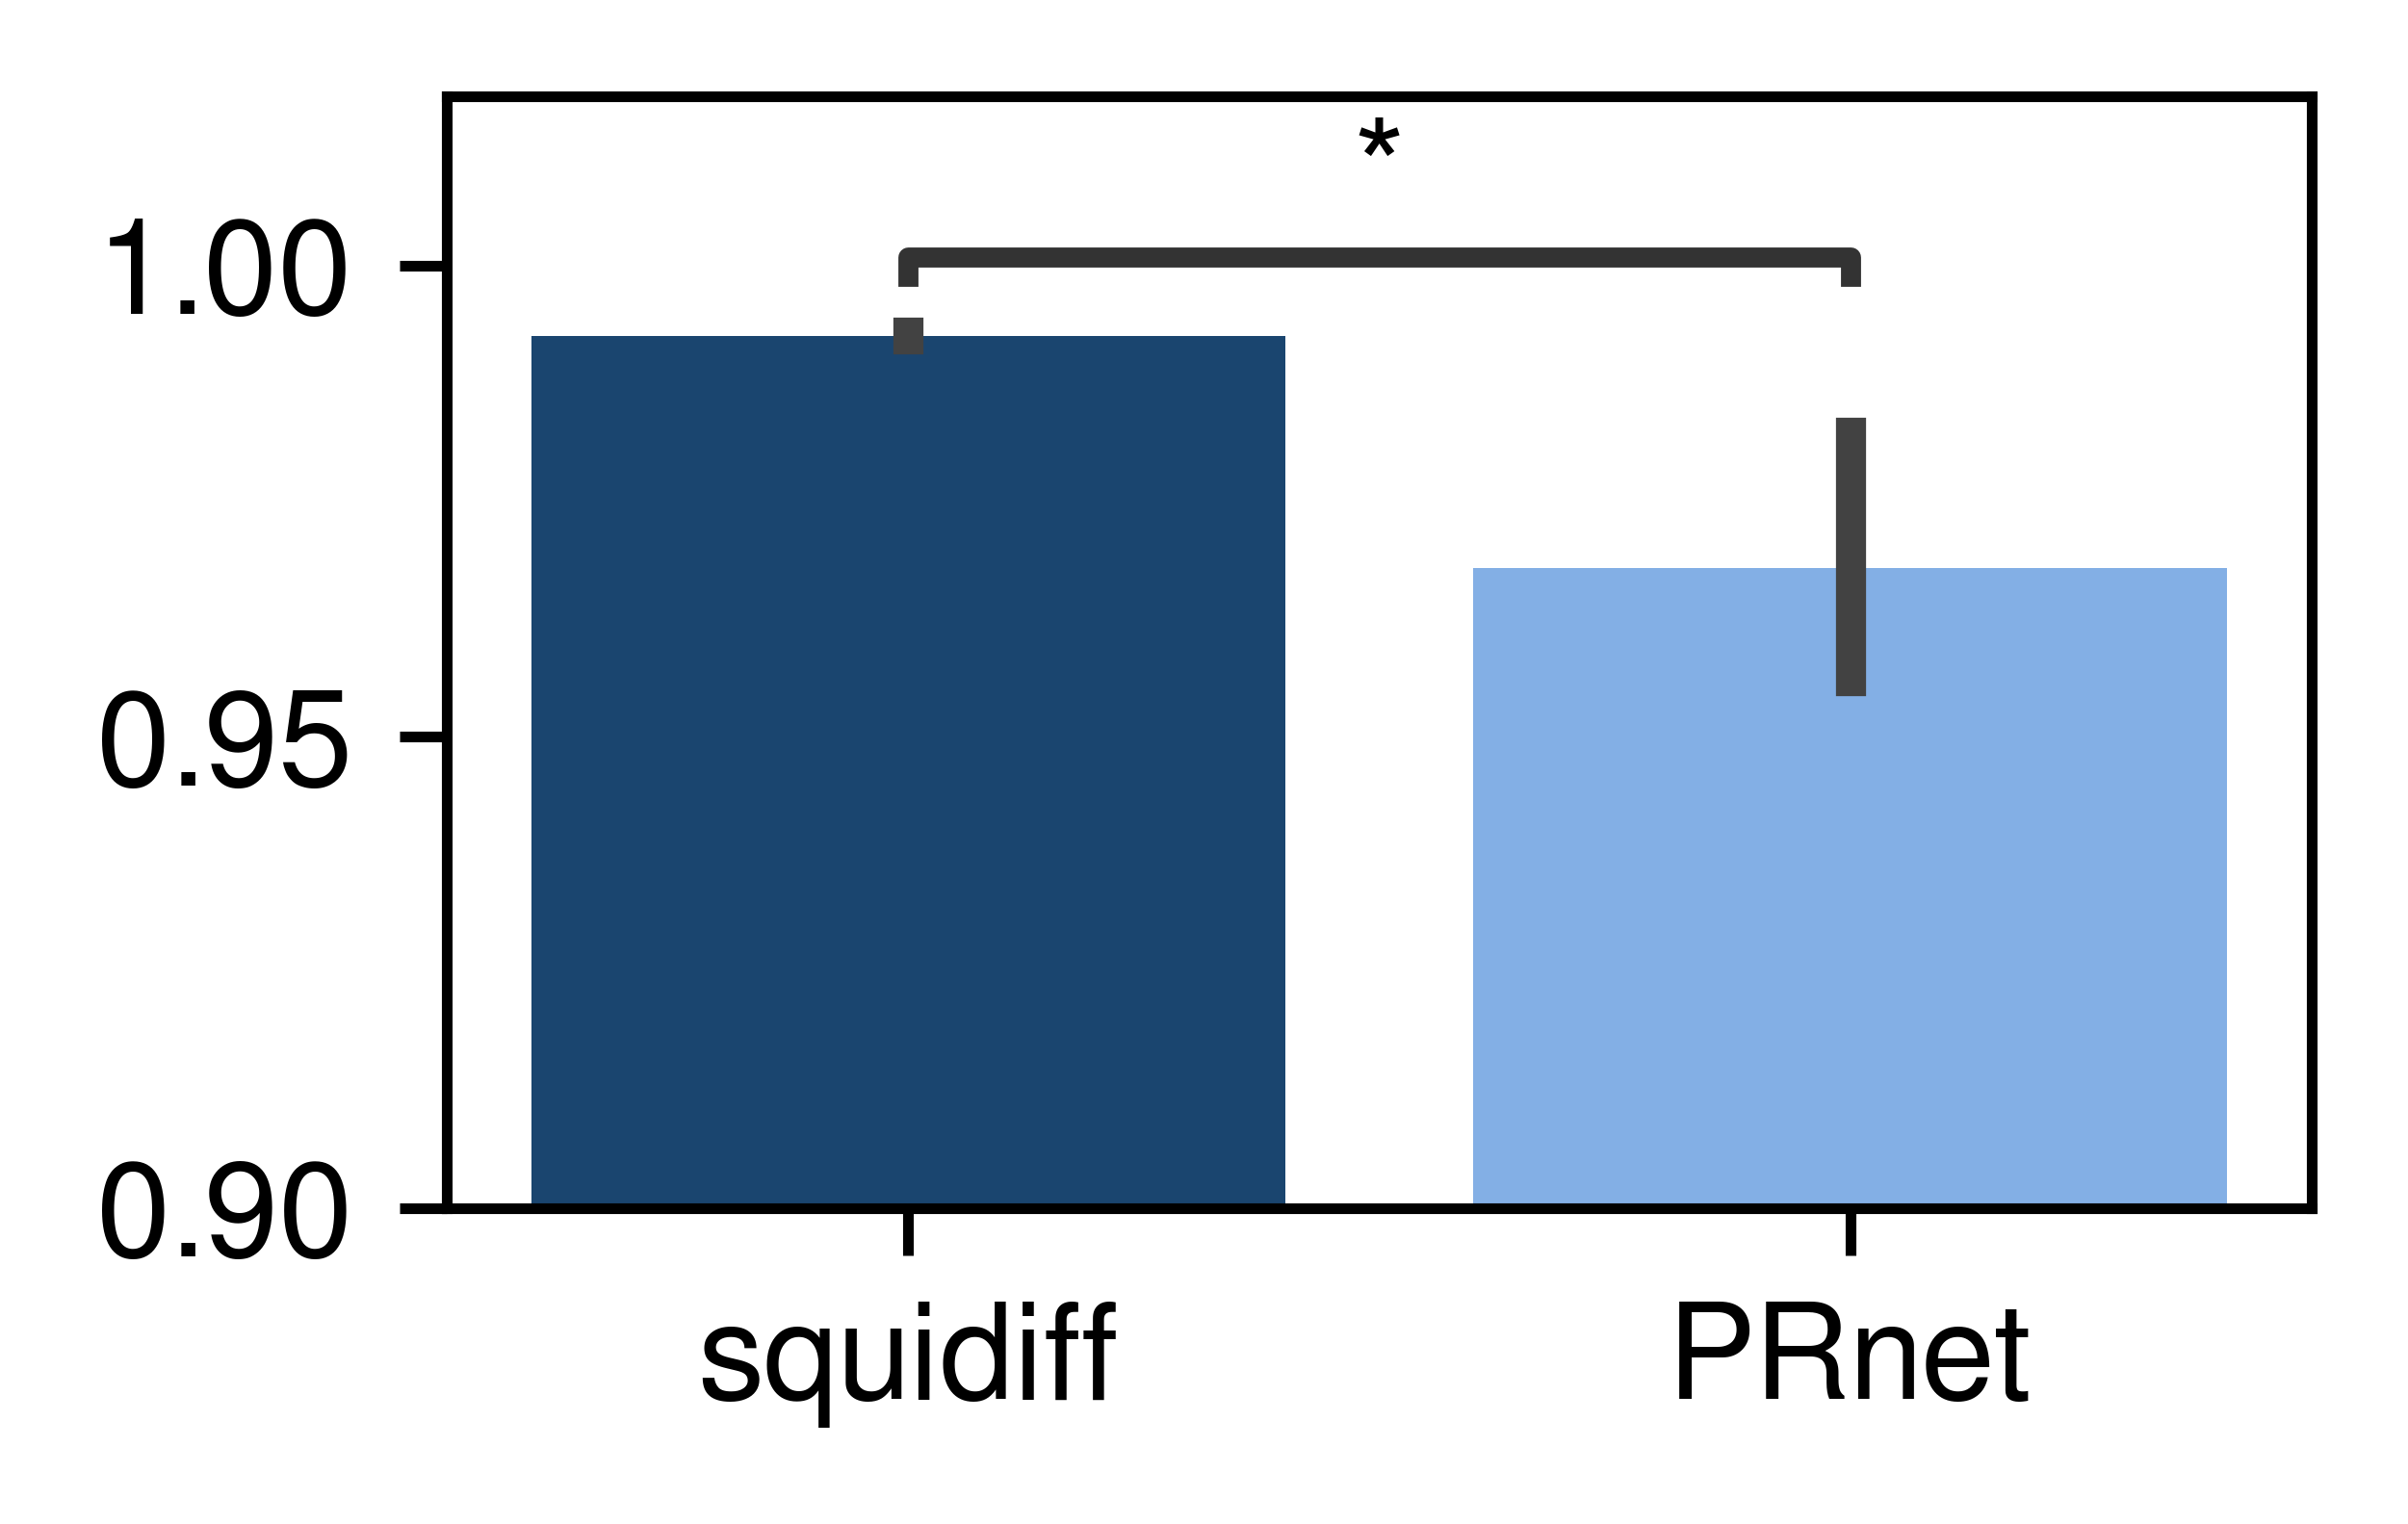

In [18]:
r2_squidiff = pd.read_csv('sciplex_squidiff_r_unseen_drug.csv',index_col = 0
                               )
r2_prnet = pd.read_csv('../Squidiff_project/PRnet/sciplex_PRnet_r_unseen_drug.csv',index_col = 0
                               )

plot_comp(score1 = r2_squidiff,
          score2 = r2_prnet,
          x='method',
          y='pearsonr'
         )

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

squidiff vs. PRnet: t-test independent samples, P_val:9.956e-04 t=7.182e+00


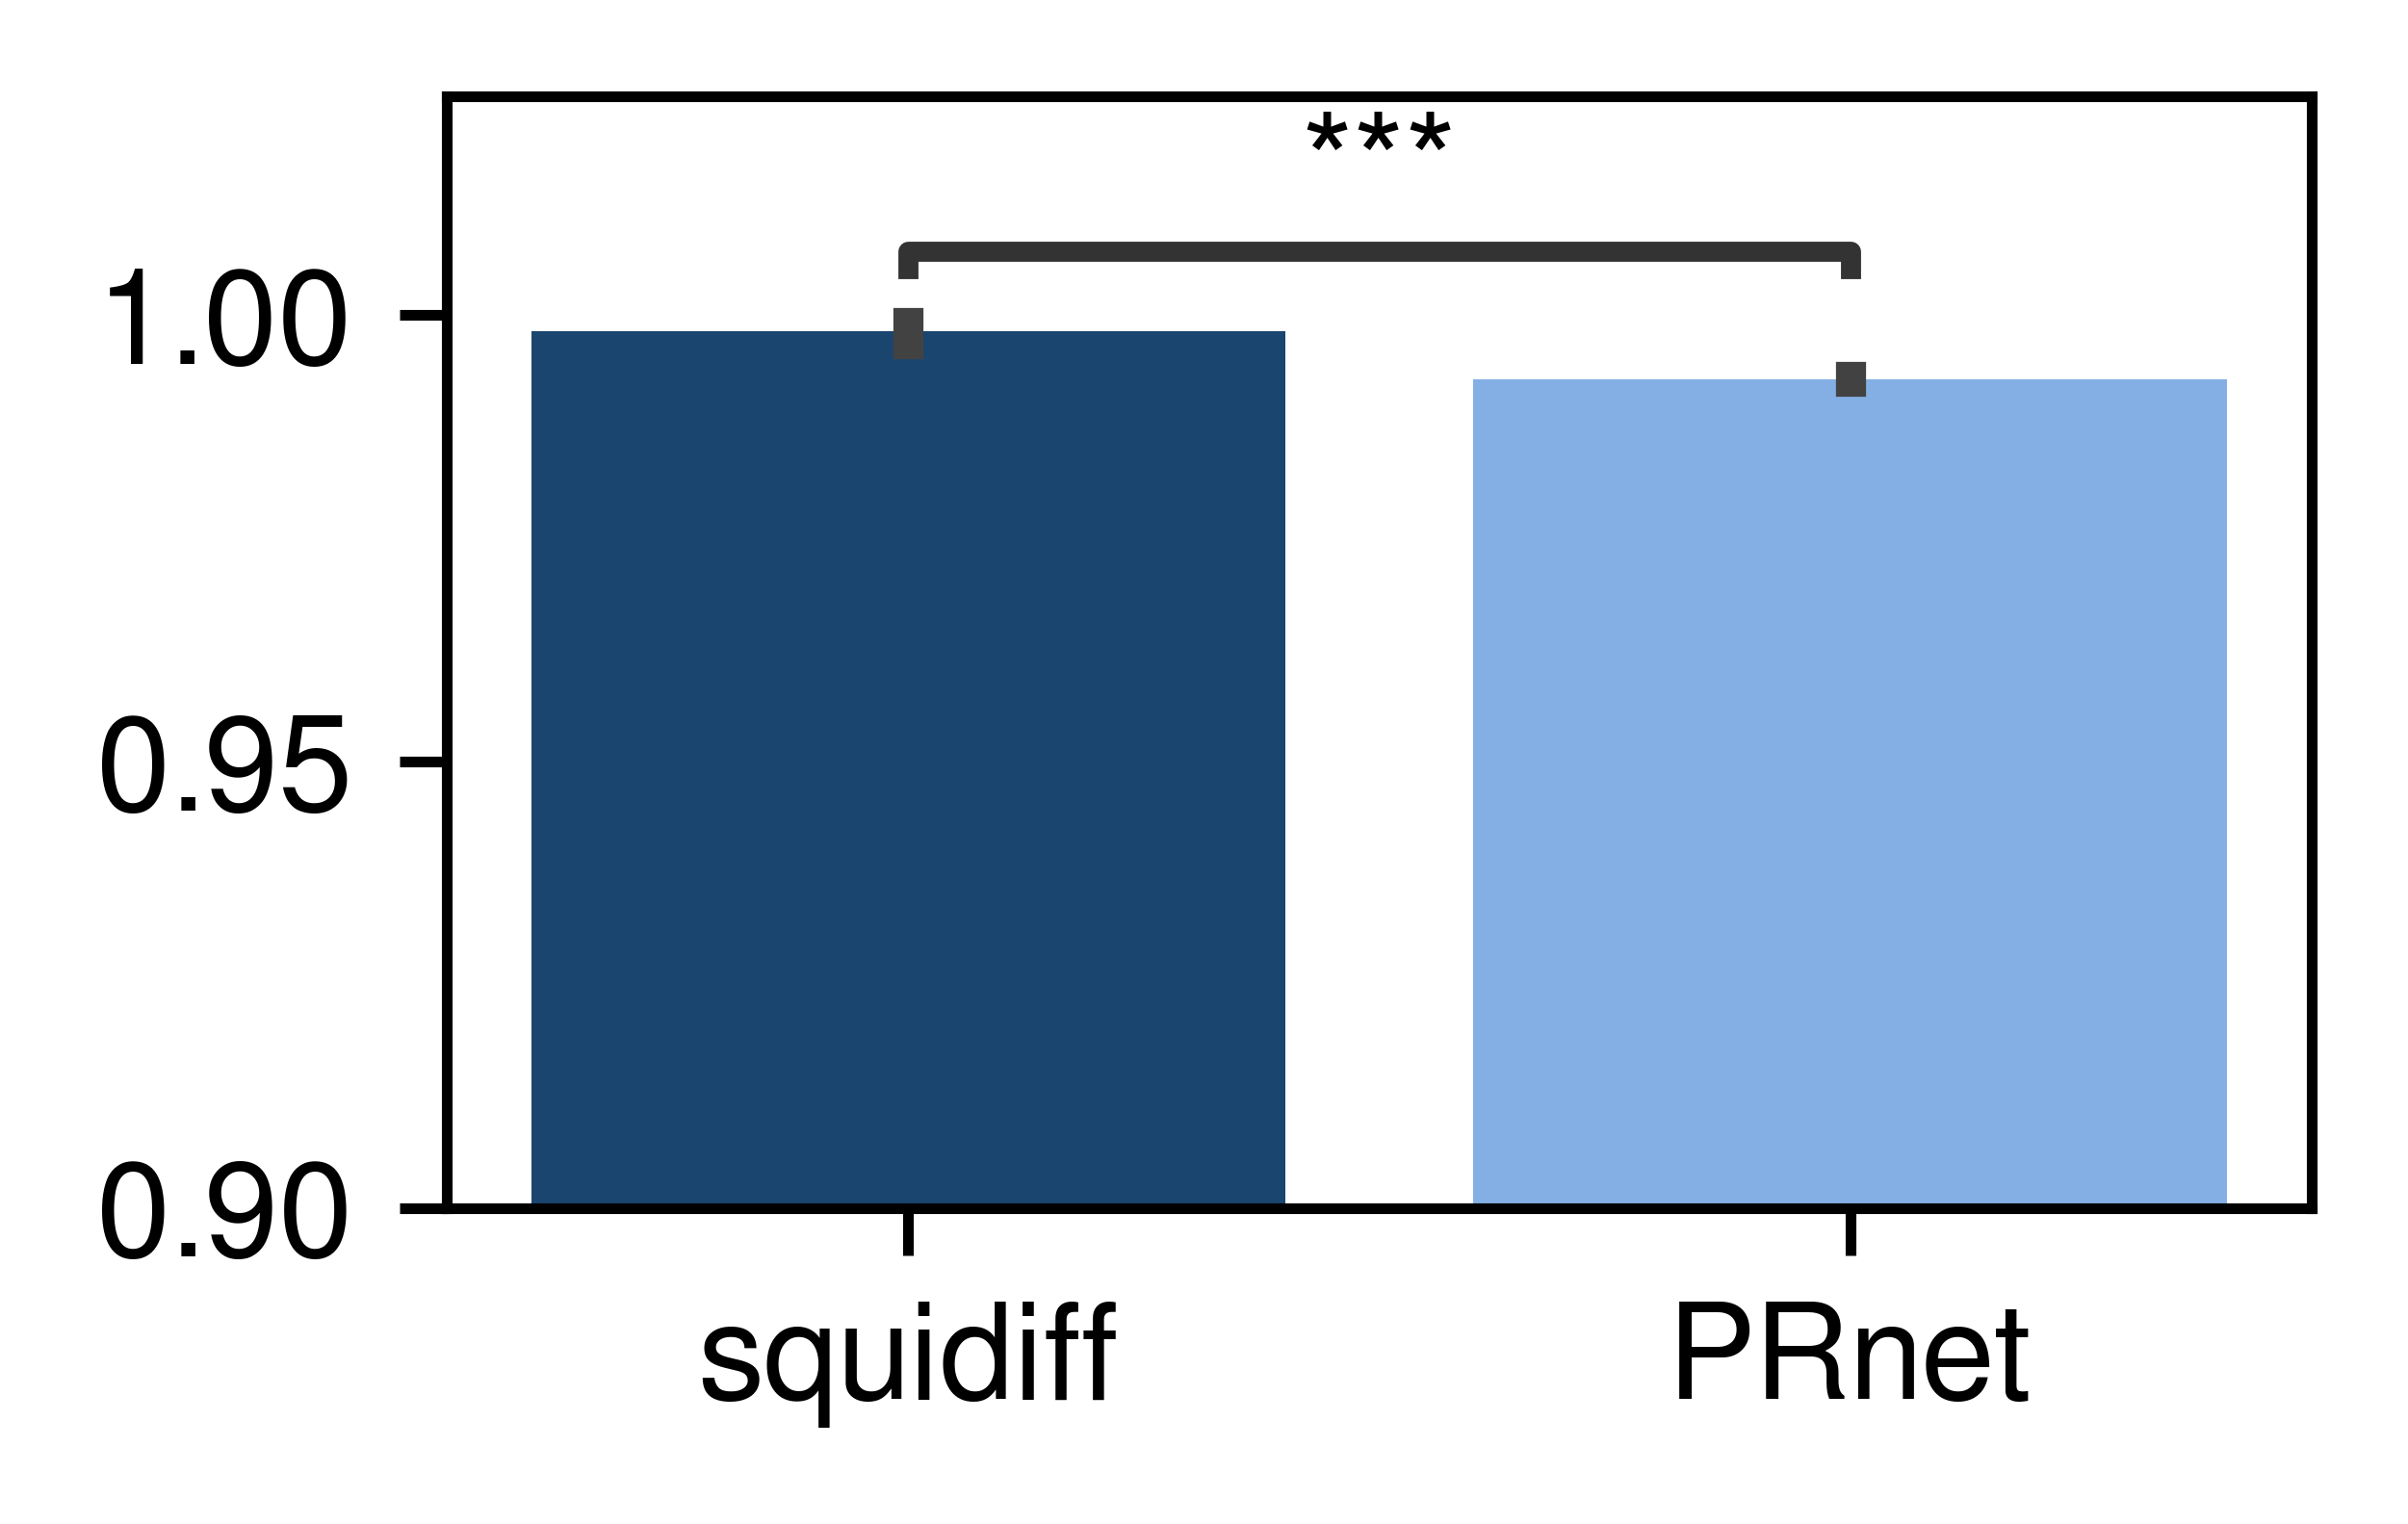

In [19]:
pearsonr_squidiff = pd.read_csv('sciplex_squidiff_pearsonr_random.csv',index_col = 0
                               )
pearsonr_prnet = pd.read_csv('../Squidiff_project/PRnet/sciplex_PRnet_pearsonr_unseen_random.csv',index_col = 0
                               )
plot_comp(score1 = pearsonr_squidiff,
          score2 = pearsonr_prnet,
          x='method',
          y='pearsonr'
         )

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

squidiff vs. PRnet: t-test independent samples, P_val:7.463e-02 t=1.782e+00


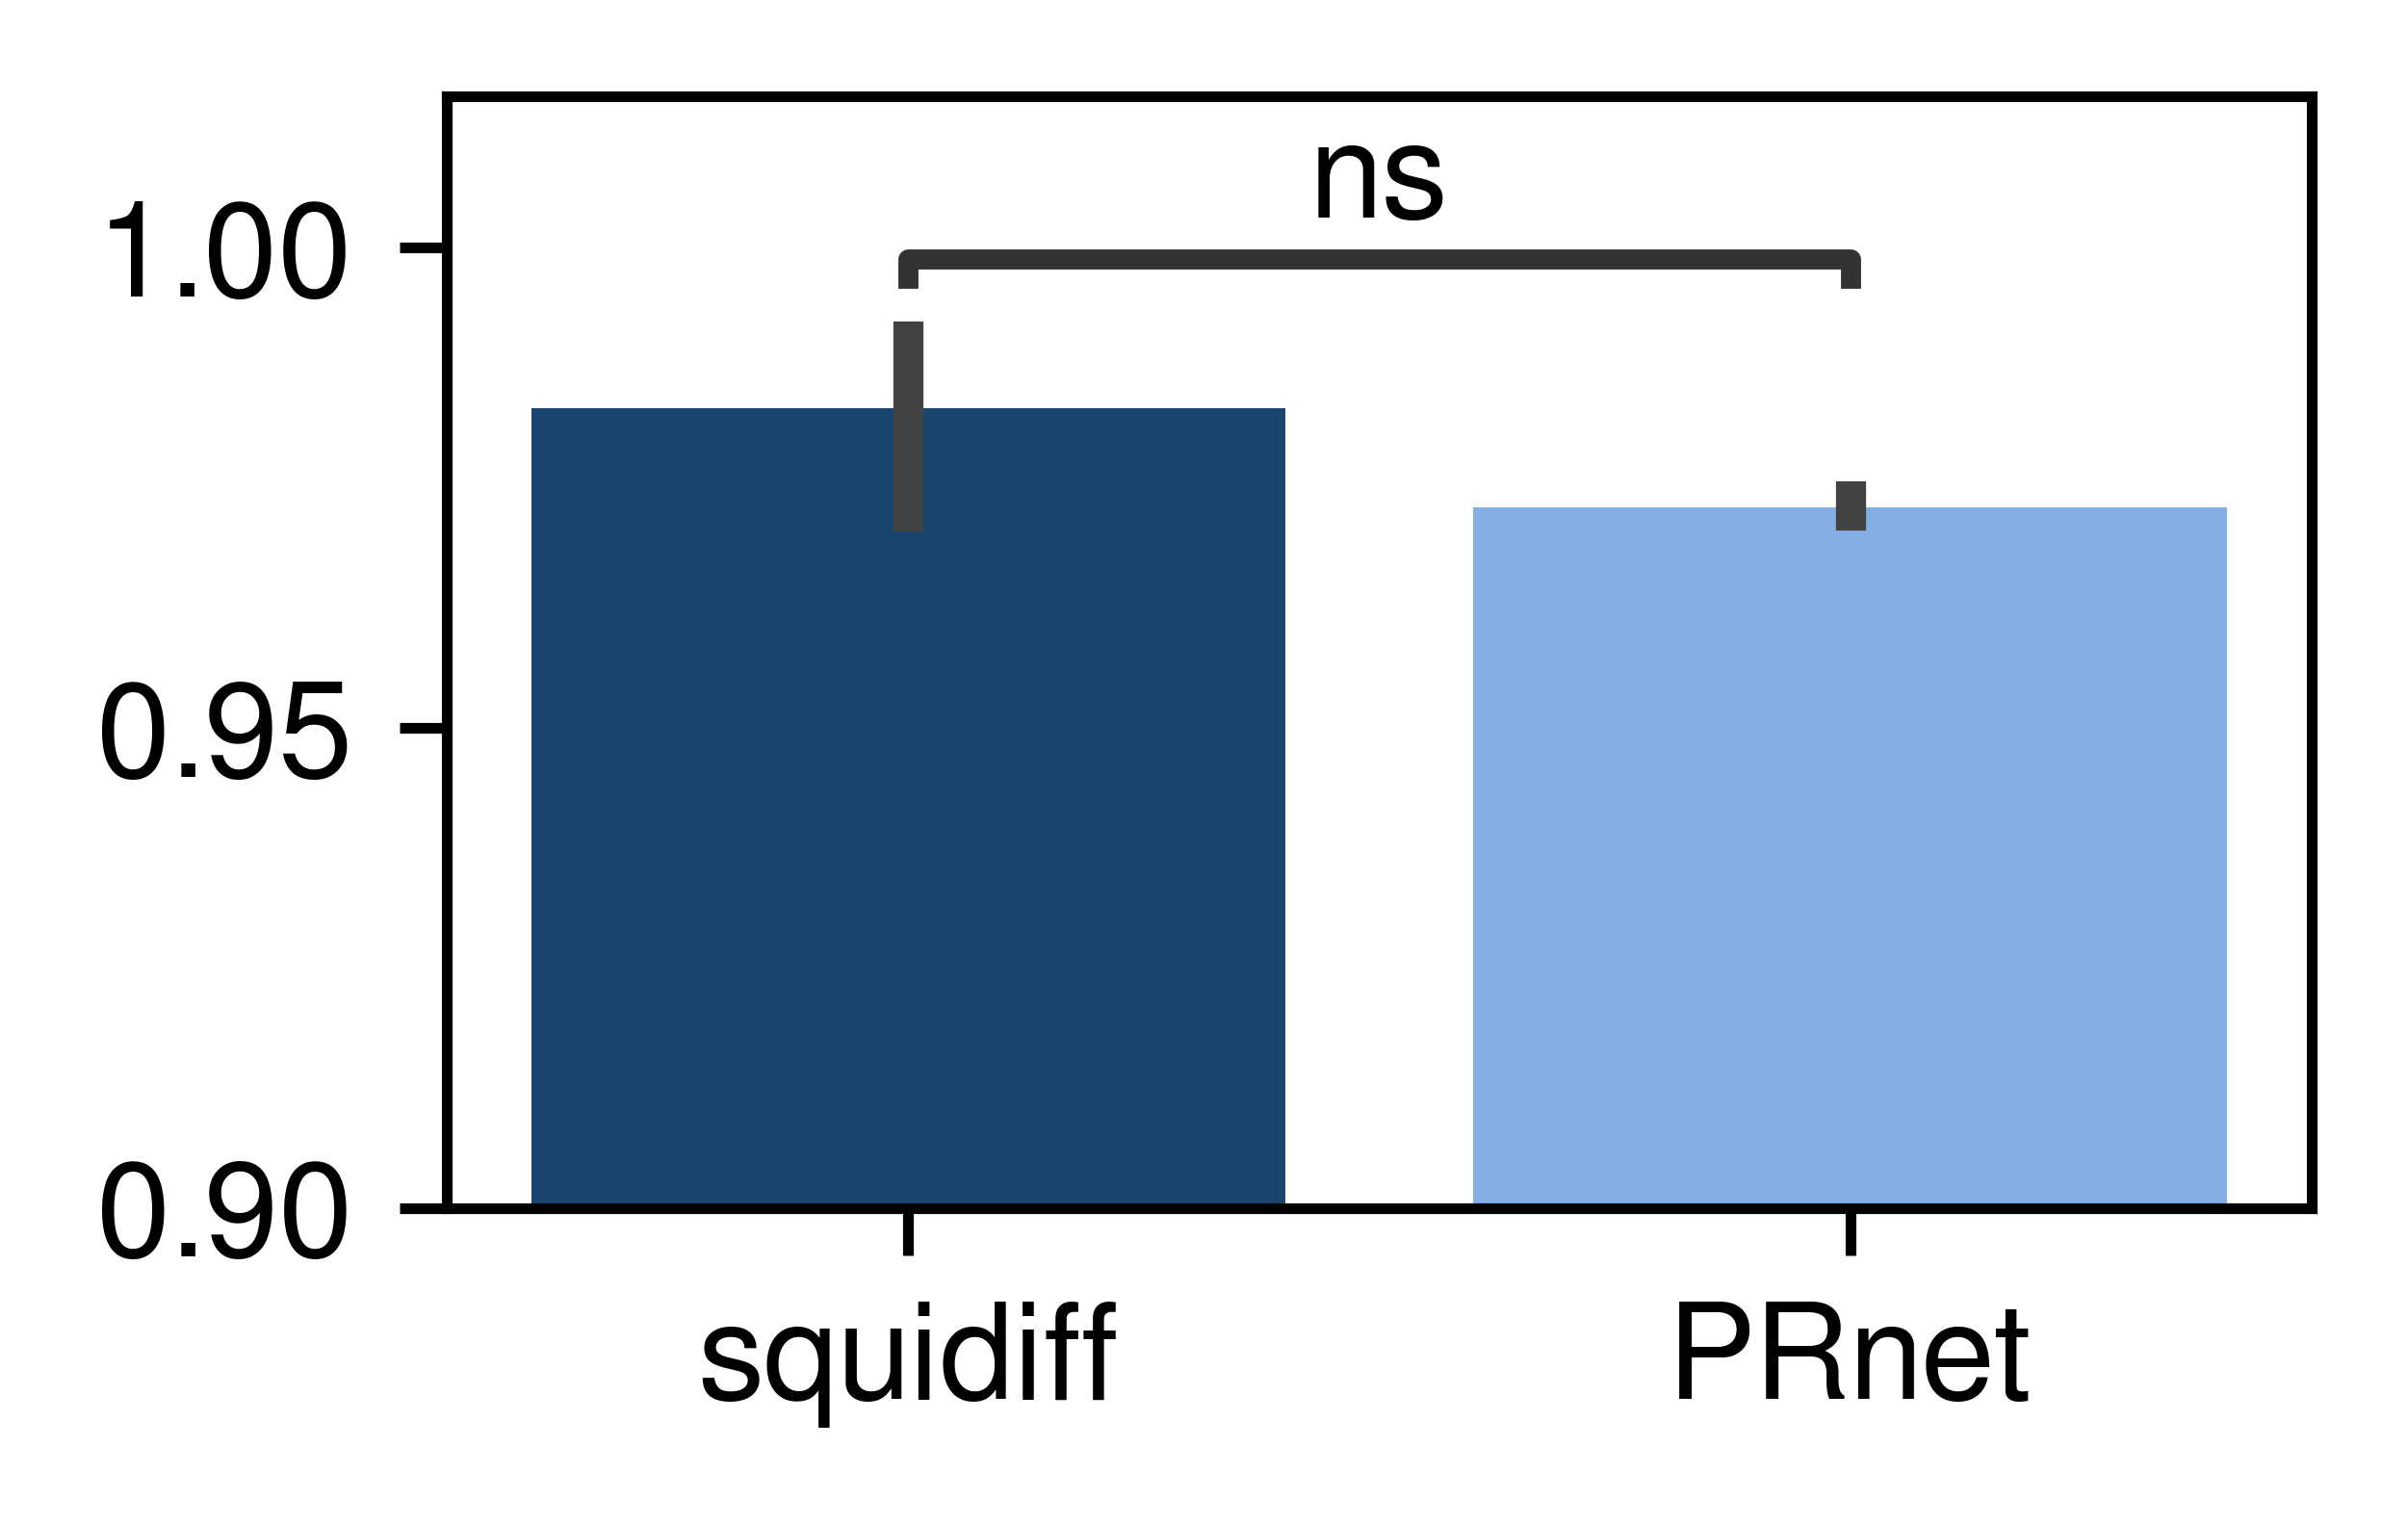

In [21]:
pearsonr_squidiff = pd.read_csv('sciplex_squidiff_r_random.csv',index_col = 0
                               )
pearsonr_prnet = pd.read_csv('../Squidiff_project/PRnet/sciplex_PRnet_r_unseen_random.csv',index_col = 0
                               )
plot_comp(score1 = pearsonr_squidiff,
          score2 = pearsonr_prnet,
          x='method',
          y='pearsonr'
         )